## Libraries

In [1]:
mogp_dir <- "/gpfs7kw/linkhome/rech/genloc01/udu91zn/mogp_emulator"
## important to add "import warning" at MutliOutputGP.py

source('/gpfswork/rech/omr/udu91zn/HighTune_R/BuildEmulator/BuildEmulator.R')
source('/gpfswork/rech/omr/udu91zn/HighTune_R/HistoryMatching/HistoryMatching.R')
#source("HistoryMatching/impLayoutplot.R")
source('/gpfswork/rech/omr/udu91zn/HighTune_R/BuildEmulator/utils.R')

library(comprehenr)
library(caret)
library("future.apply") #important for parallel version of ImplausibilityMOGP function in HistoryMatching.R

far library : Modelization for Functional AutoRegressive processes

version 0.6-4 (2014-12-07)

Warning message:
“package ‘fields’ was built under R version 3.6.3”Spam version 2.2-2 (2019-03-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 
Warning message:
“package ‘lhs’ was built under R version 3.6.3”Warning message:
“package ‘mco’ was built under R version 3.6.3”Warning message:
“package ‘mvtnorm’ was built under R version 3.6.3”Warning message:
“package ‘ncdf4’ was built under R version 3.6.3”Warning message:
“package ‘shape’ was built under R version 3.6.3”Warning message:
“package ‘tensor’ was bu

# Read data 

In [2]:
my_bounds <- data.frame(c(0, 20), c(0, 20))

In [3]:
set.seed(42)
inputs <- as.data.frame(2*maximinLHS(20, 2)-1)
inputs_unscaled <- rangeUnscale(inputs, my_bounds)
names(inputs) <- c('G','F')
names(inputs_unscaled) <- c('G','F')
inputs_unscaled

G,F
13.365014,15.63072615
5.280125,5.41877162
9.599716,11.87926595
15.818570,8.10798707
19.097832,10.98027870
14.963690,2.26496663
6.168736,0.08427752
3.086083,16.38590718
4.861211,6.12489583
8.524791,7.58155422


In [4]:
write.csv(inputs_unscaled,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_inputs_newPCA_PhysPrior_OMIP_wave1.csv", row.names = FALSE)

In [5]:
set.seed(42)
                       
#Load outputs and select variables you want to keep
outputs <- read.csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_OMIP_wave1.csv")
                         
#Add some noise (here no noise added)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

G,F,Noise,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
0.33650141,0.56307262,0.68547922,-0.8462271,-0.3373734,-0.10524062,-0.259807934,0.12814060,0.27762763,0.04957604
-0.47198754,-0.45812284,-0.28234909,-5.7944970,-7.0284029,0.07076547,-0.052793513,-0.03434477,0.04567848,0.09745138
-0.04002841,0.18792659,0.18156421,-4.0756915,-2.9009243,0.14444759,-0.007404986,0.02524116,0.05949832,0.14356570
0.58185696,-0.18920129,0.31643130,6.3040161,-1.0265353,-0.20174348,0.749459018,0.44753317,-0.08647414,0.98731620
0.90978323,0.09802787,0.20213416,9.7195218,1.7450873,-1.27231915,-1.266780079,0.13242724,-0.44855834,0.17810335
0.49636895,-0.77350334,-0.05306226,9.5946869,-0.6097061,0.05697596,1.321175771,0.15100963,-0.68742148,-0.71549618


### Training Emulators

In [6]:
#choices.new <- choices.default
#choices.new$lm.maxdf = 3 ### NOT WORKING
#choices.new$lm.tryFouriers=TRUE  ### NOT WORKING

In [7]:
TestEm <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:2])  #important to put this line
                            #Choices = lapply(1:length(outputs), function(k) choices.new))

[1] "Max reduction is 2.77802407541395 using G"
[1] "Max reduction is 1.14718155343747 using F"
[1] "Max reduction is 0.666420421131646 using G"
[1] "Max reduction is 0.810454725601555 using F"
[1] "Max reduction is 0.203464239006182 using Three Way Interactions with G"
[1] "Max reduction is 0.0928108606385237 using Three Way Interactions with F"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ G + I(G^2) + F + I(F^2) + I(F * G) + I(G * 
    F * G) + I(F * F * G), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52139 -0.33892 -0.00191  0.20508  0.85516 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -2.6775     0.2099 -12.757 2.44e-08 ***
G             10.8617     0.2887  37.626 7.98e-14 ***
I(G^2)         3.8321     0.4179   9.170 9.05e-07 ***
F             -4.2643     0.3300 -12.921 2.11e-08 ***
I(F^2)         3.1958     0.4116   7.765 5.10e-06 ***
I(F * G)      -6.0687     0.3366 -18.027 4.67e-10 ***
I(

In [8]:
tObs <- read.csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_obs_nonoise_newPCA_PhysPrior_OMIP_wave1.csv")
tObs <- as.vector(t(tObs))

tDisc <- rep(0, length(outputs)) ### variances
#apply(tObs[1:2] - TestEm$mogp$predict(array(c(inputs$G, inputs$F), dim=c(20,2)))$mean, 1 , var)
tObsErr <- rep(0, length(outputs))

## LOO

In [9]:
cands <- names(tData)[1:2]

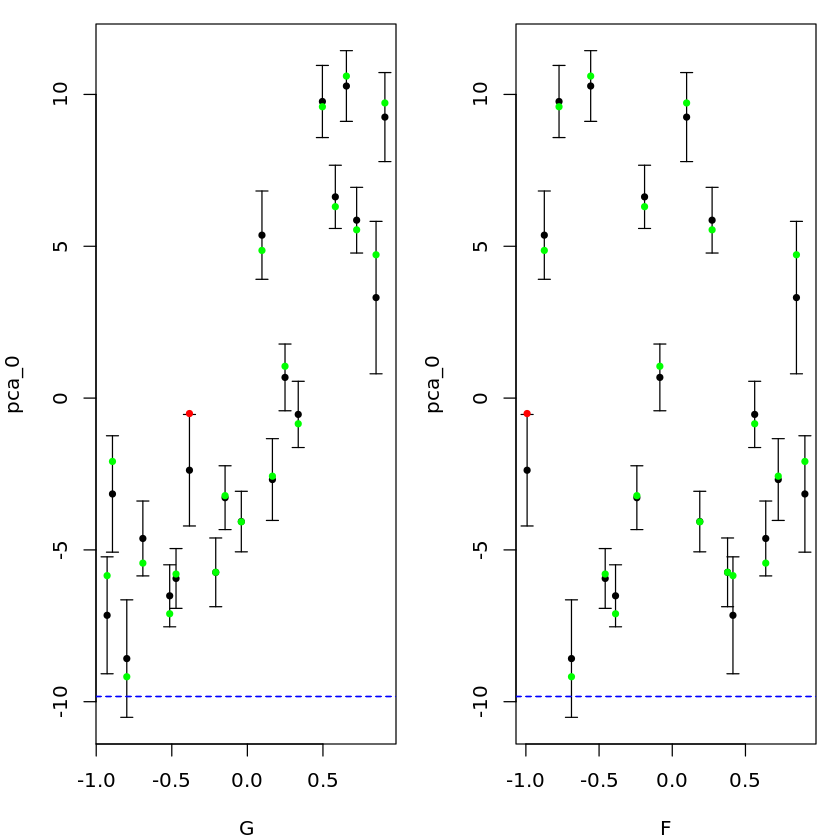

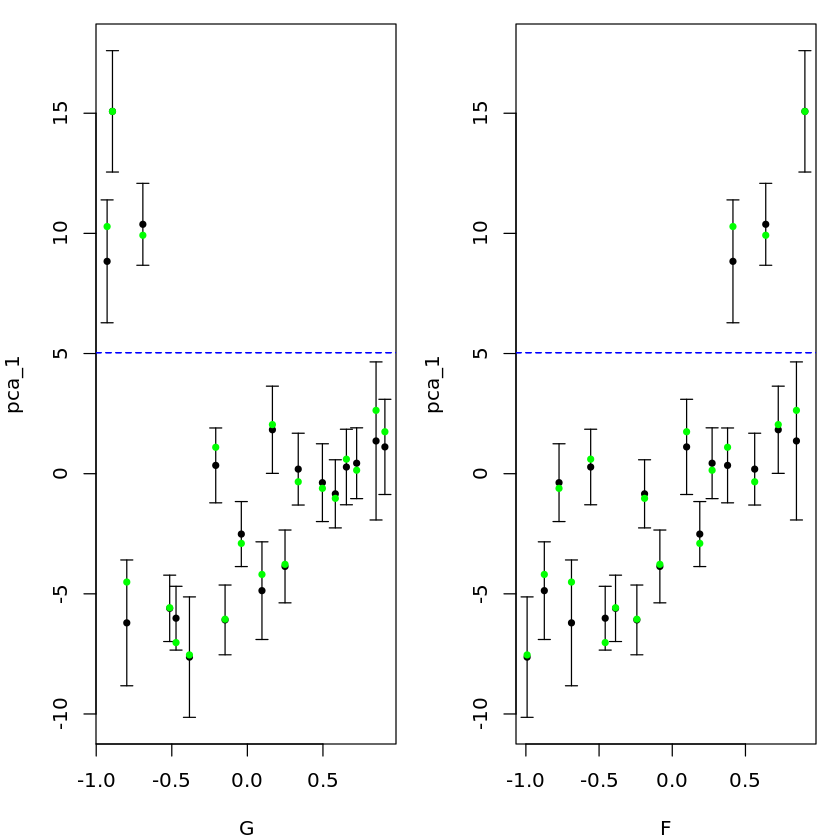

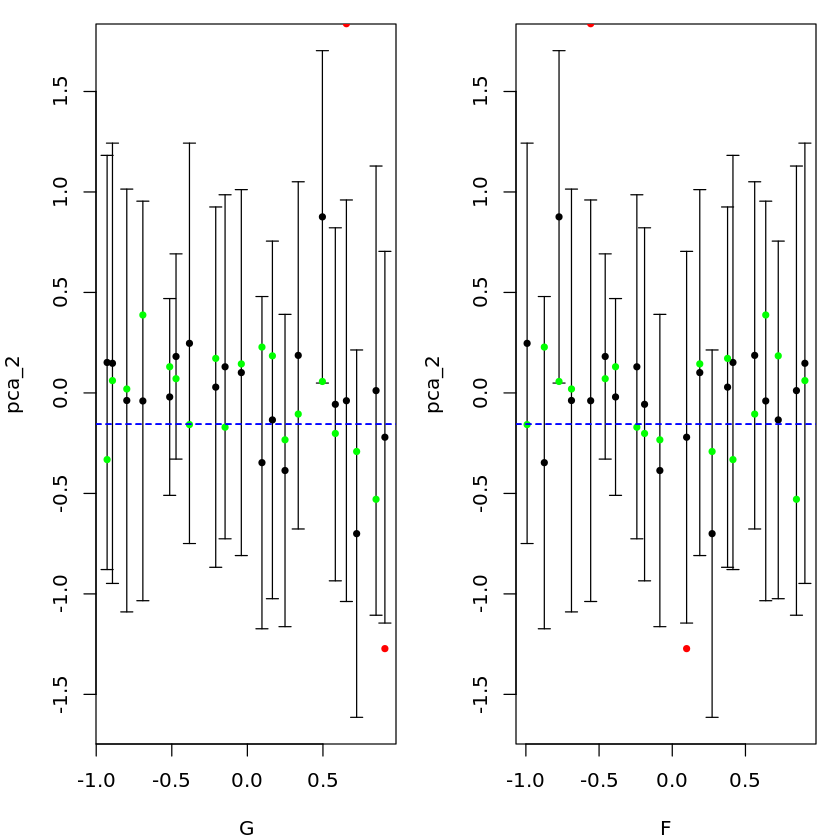

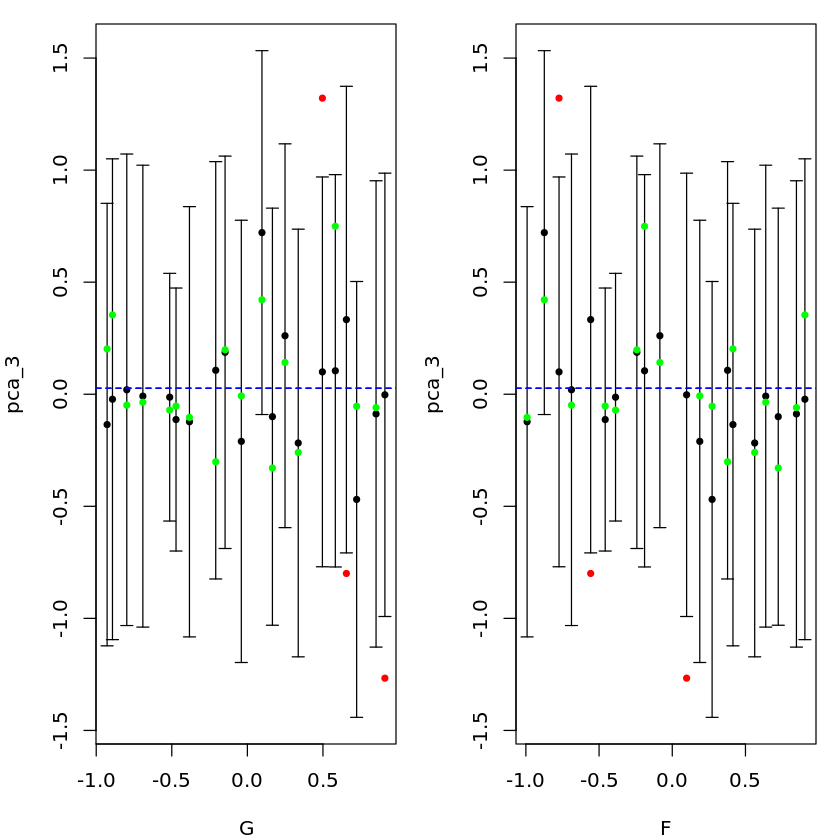

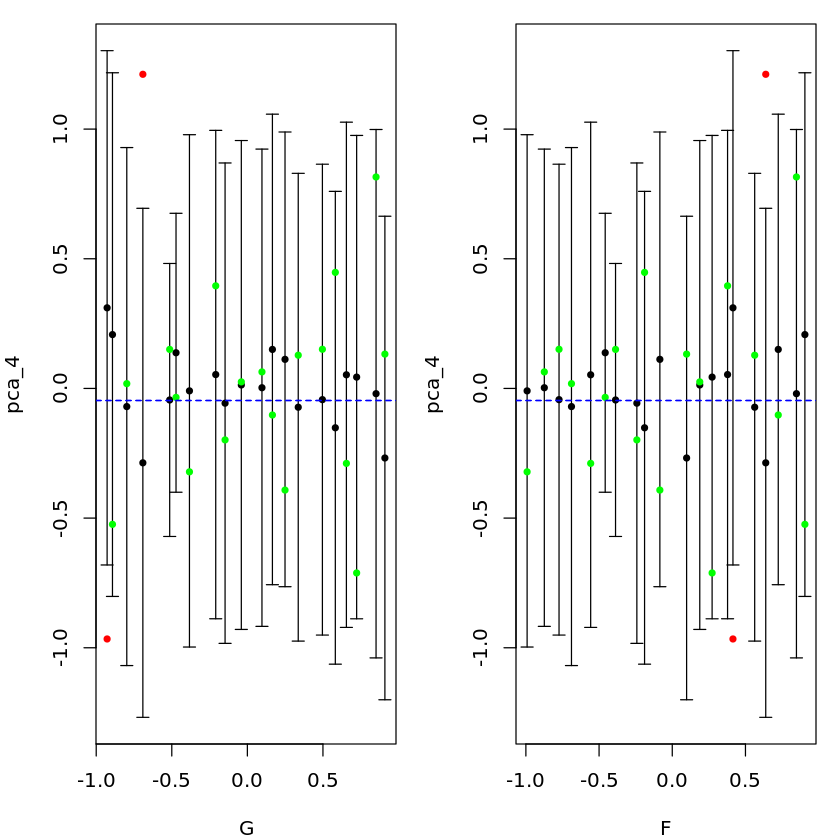

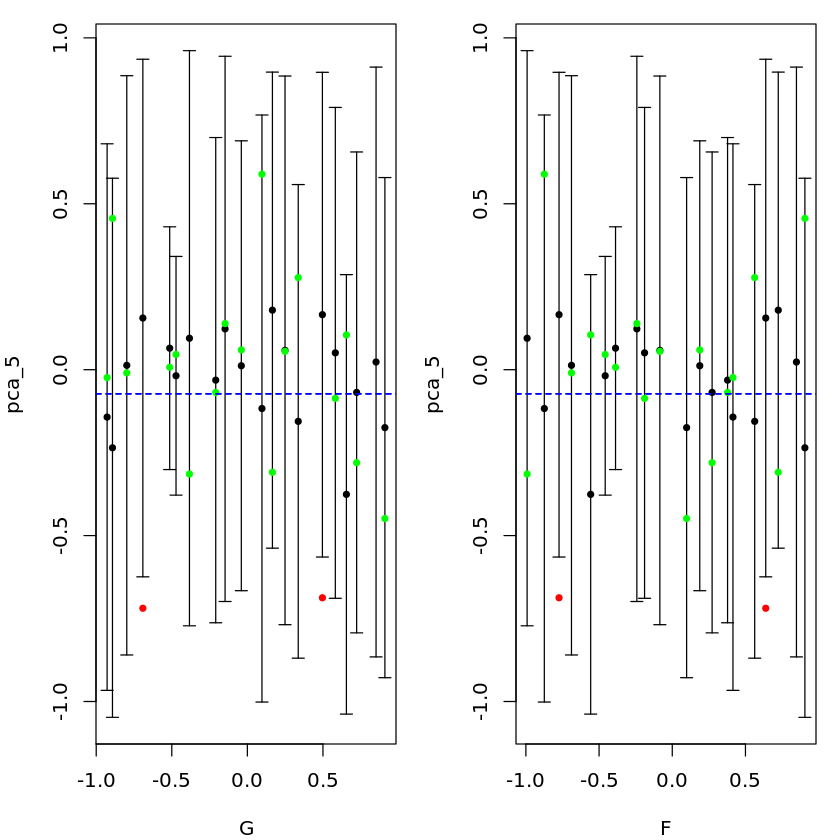

In [10]:
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 1, ParamNames = cands, Obs = tObs[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 2, ParamNames = cands, Obs = tObs[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 3, ParamNames = cands, Obs = tObs[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 4, ParamNames = cands, Obs = tObs[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 5, ParamNames = cands, Obs = tObs[5], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 6, ParamNames = cands, Obs = tObs[6], ObsErr = 0.)#tLOOs <- 

## History Matching
* Observations discrepancy variances in *tDisc* (here sets to 0)
* Observations errors in *tObsErr* (here set to 0)

In [11]:
future::availableCores() 

Slurm 
   20

In [12]:
set.seed(42)
sample_size <- 1000000
nparam <- length(names(TestEm$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(TestEm$fitting.elements$Design)

In [13]:
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 15.307  11.117   4.431 

In [14]:
ImpData_wave1 = cbind(Xp, Timps)
print(object.size(ImpData_wave1), units="Mb")

68.7 Mb


In [15]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off?
cutoff_vec <- 3 #the implausibility cut off

param.def = data.frame(G=c(1), F=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

     G F
1 -0.9 0


In [16]:
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=TestEm$mogp$n_emulators, whichMax=valmax+1)
NROY1 <- which(rowSums(Timps <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
ratio1 <- length(NROY1)/dim(Xp)[1]
ratio1

[1] 0.017931

#### 20 samples for training, 1 000 000 points for test

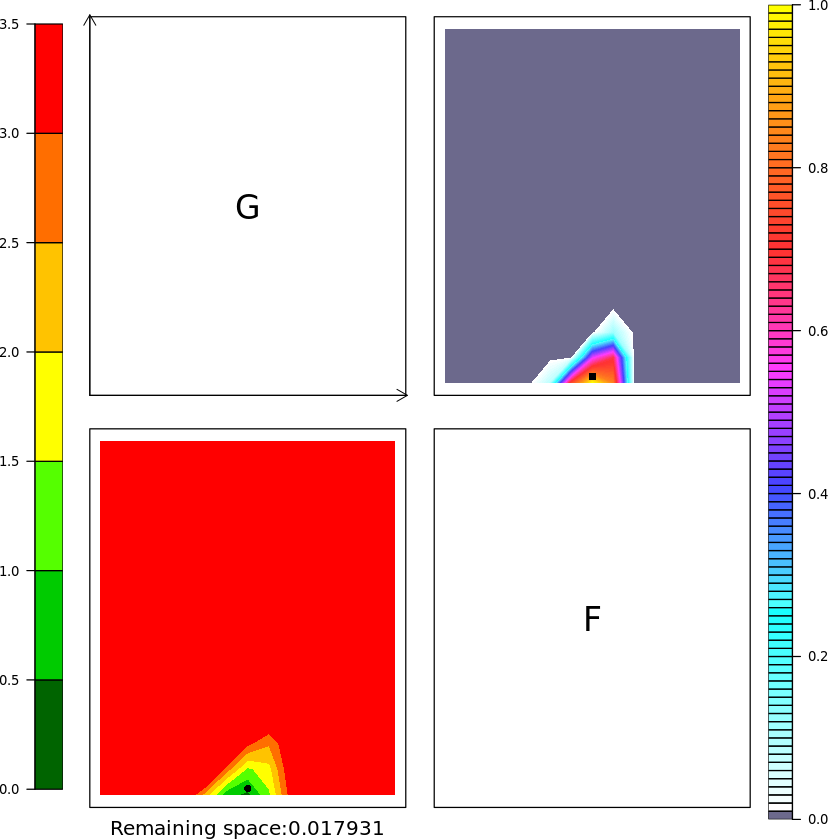

In [97]:
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY1)/dim(Xp)[1],sep=""), side=1)

In [17]:
indminImp <- order(apply(Timps[NROY1,], 1, FUN=max))
rangeUnscale(Xp[NROY1[indminImp[1:10]],], my_bounds)

,G,F
552882,0.01512669,9.668006
120266,0.03147231,9.661847
77683,0.04061476,9.659172
564830,0.05487999,9.656454
724923,0.02368537,9.658353
945155,0.02911310,9.656290
838709,0.04462391,9.648206
51191,0.06403481,9.644456
58241,0.08462595,9.631780
764374,0.05118809,9.633979


In [18]:
colMeans(rangeUnscale(Xp[NROY1,], my_bounds))

G        F 
 1.05727 10.23783

In [19]:
length(NROY1)

[1] 17931

# Wave2

In [101]:
20/ratio1

[1] 1115.387

In [102]:
set.seed(42)

designpoints <- data.frame()

while (nrow(designpoints) < 20) {
        tmp <- as.data.frame(2*maximinLHS(ceil(20/ratio1), 2)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        selectionP <- tmp[NROYtmp,]
        row.names(selectionP) <- NULL ## to avoid double index
        designpoints <- rbind(designpoints,selectionP)
        print(nrow(designpoints))
        flush.console()
        } 

designpoints <- designpoints[sample(nrow(designpoints),20),]
row.names(designpoints) <- NULL

designpoints_denorm <- rangeUnscale(designpoints, my_bounds)

[1] 19
[1] 41


In [103]:
designpoints_denorm

G,F
1.03847623,9.758474
0.12524626,10.322096
0.08556419,9.525610
0.85014266,11.642330
0.12735556,11.877320
1.17178259,10.481509
0.32691004,10.924906
1.28809850,10.955206
0.60145138,9.734888
1.34986138,9.429944


In [104]:
write.csv(designpoints_denorm,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_OMIP_wave2.csv", row.names = FALSE)

In [105]:
inputs <- designpoints

#Load outputs and select variables you want to keep
outputs <- read.csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_OMIP_wave2.csv")
                         
#Add some noise (here no noise added)
set.seed(42)

N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
tData

G,F,Noise,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
-0.8961524,-0.024152624,0.68547922,-8.929592,4.772422,0.157045217,0.030198996,0.308120775,-0.15525064,-0.003802888
-0.9874754,0.032209564,-0.28234909,-8.147921,6.924481,0.005986408,0.005625754,0.272509307,-0.09065002,-0.318231601
-0.9914436,-0.047438955,0.18156421,-8.613009,6.094114,-0.398820021,-0.074399106,-0.317297351,0.03847482,-0.276644651
-0.9149857,0.164232972,0.31643130,-7.729720,7.214751,-0.128363626,-0.071850847,0.039158055,-0.09871973,-0.410880943
-0.9872644,0.187731994,0.20213416,-7.133500,8.272090,-0.040538259,-0.150893365,0.131023875,0.06080212,-0.467262895
-0.8828217,0.048150880,-0.05306226,-8.527989,5.842331,-0.222909617,-0.141702936,-0.145743403,0.03497989,-0.396721467
-0.9673090,0.092490574,0.75576100,-7.888079,7.252535,-0.301117483,0.007615665,0.139603067,-0.02313643,-0.388541218
-0.8711901,0.095520617,-0.04732952,-8.313164,5.956473,-0.043923711,-0.183450245,0.189894563,-0.10481929,-0.513526771
-0.9398549,-0.026511195,1.00921186,-8.768431,5.524115,0.001576059,0.114790710,0.072068196,-0.23558286,-0.230746677
-0.8650139,-0.057005636,-0.03135705,-9.171767,4.104890,0.074411408,0.030170342,-0.011032177,-0.09191352,-0.204679783


In [106]:
TestEm2 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:2])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.258191611628437 using F"
[1] "Max reduction is 0.20404182801185 using G"
[1] "Max reduction is 0.014408620528598 using G"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ F + G + I(G^2) + I(G * F), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09635 -0.01976 -0.01053  0.01889  0.09302 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   -3.301      2.514  -1.313  0.20886   
F              2.356      2.422   0.973  0.34611   
G             16.158      5.541   2.916  0.01064 * 
I(G^2)        11.198      3.048   3.674  0.00225 **
I(G * F)      -4.025      2.581  -1.559  0.13972   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04306 on 15 degrees of freedom
Multiple R-squared:  0.9946,	Adjusted R-squared:  0.9931 
F-statistic: 688.3 on 4 and 15 DF,  p-value: < 2.2e-16

[1] "1 I(G * F)"

Call:
lm(formula = pca_0 ~ F + G + I(G^2), data = tData)


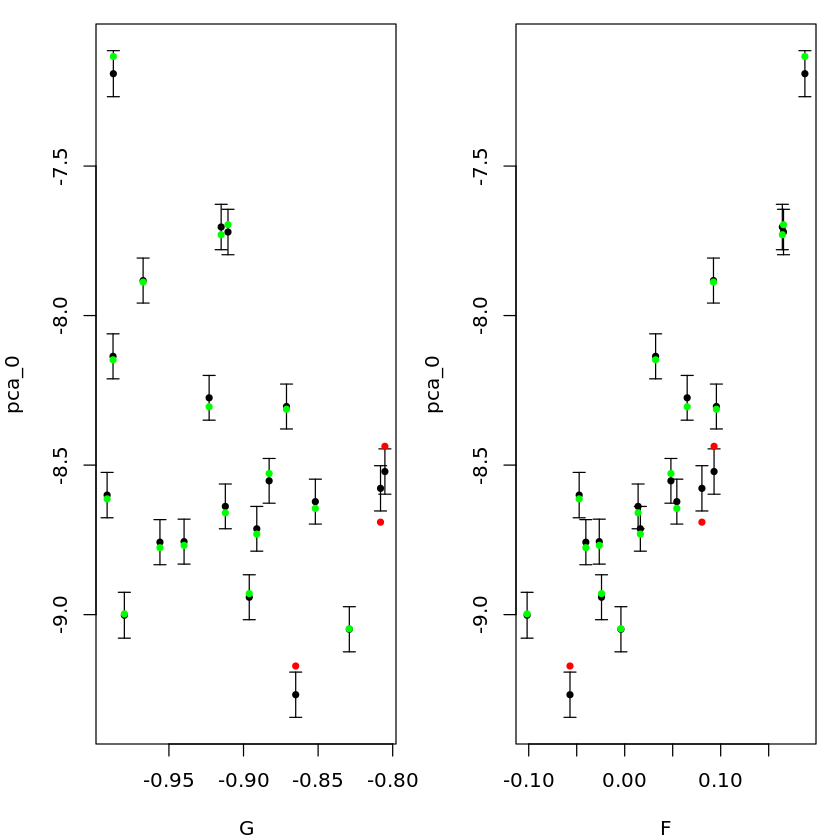

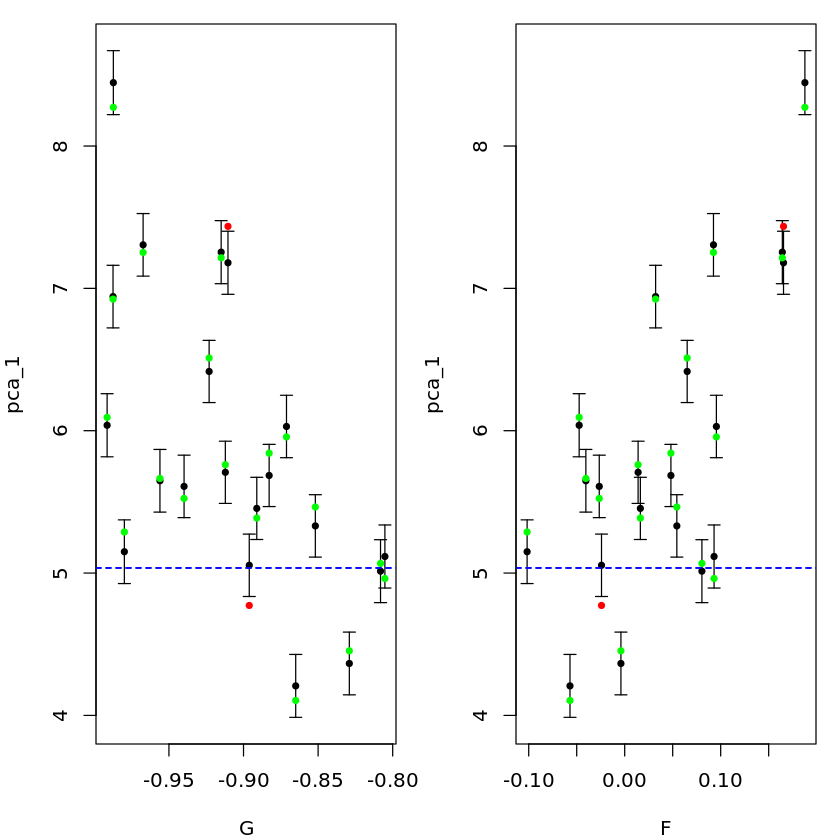

In [107]:
cands <- names(tData)[1:2]
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 1, ParamNames = cands, Obs = tObs[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 2, ParamNames = cands, Obs = tObs[2], ObsErr = 0.)#tLOOs <- 

In [108]:
Timps2 <- matrix(rep(t(Timps),1), ncol=ncol(Timps), byrow=TRUE)
system.time(Timps2[NROY1,] <- ImplausibilityMOGP(NewData=Xp[NROY1,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  1.809   5.571   1.779 

In [109]:
ImpData_wave2 = cbind(Xp, Timps2)

In [111]:
valmax2 = 0 #how many outputs can be above the implausibility cut off?
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=TestEm2$mogp$n_emulators, whichMax=valmax2+1)
NROY2 <- which(rowSums(Timps2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax2)
ratio2 <- length(NROY2)/dim(Xp)[1]
ratio2

[1] 0

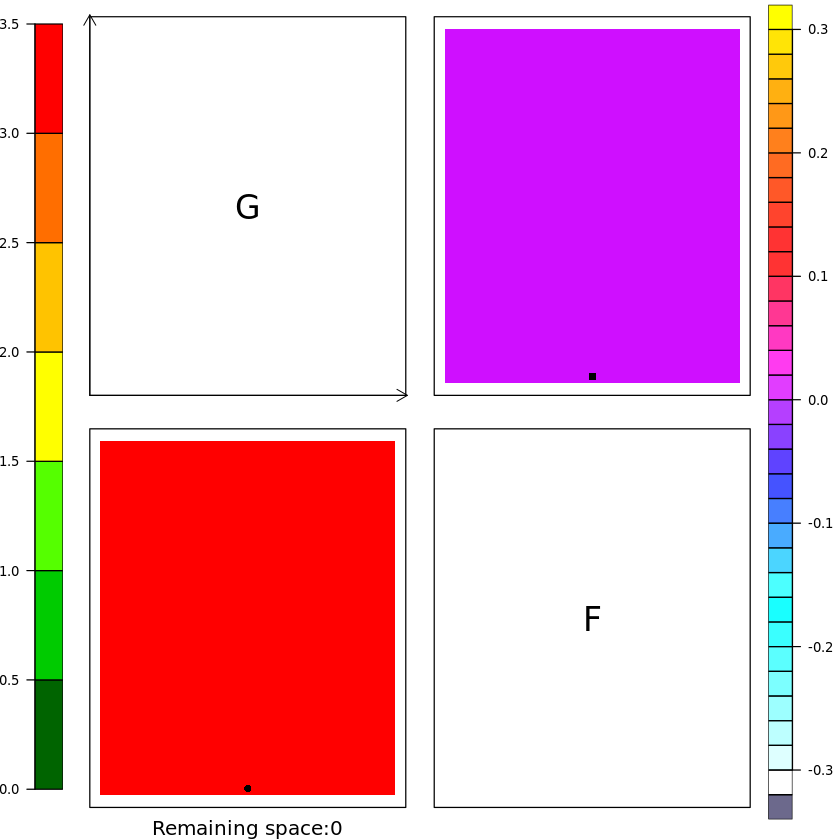

In [112]:
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY2)/dim(Xp)[1],sep=""), side=1)

In [113]:
indminImp2 <- order(apply(Timps2[NROY2,], 1, FUN=max))
rangeUnscale(Xp[NROY2[indminImp2[1:10]],], my_bounds)

,G,F
NA,NA,NA
NA.1,NA,NA
NA.2,NA,NA
NA.3,NA,NA
NA.4,NA,NA
NA.5,NA,NA
NA.6,NA,NA
NA.7,NA,NA
NA.8,NA,NA
NA.9,NA,NA


In [114]:
length(NROY2)

[1] 0

## K-means

In [20]:
library(ClusterR)

Warning message:
“package ‘ClusterR’ was built under R version 3.6.3”Loading required package: gtools
Warning message:
“package ‘gtools’ was built under R version 3.6.3”
Attaching package: ‘gtools’

The following object is masked from ‘package:pracma’:

    logit



In [21]:
preProcValues <- preProcess(Xp[NROY1,], method = c("center", "scale"))
normalizeddata <- predict(preProcValues, Xp[NROY1,])

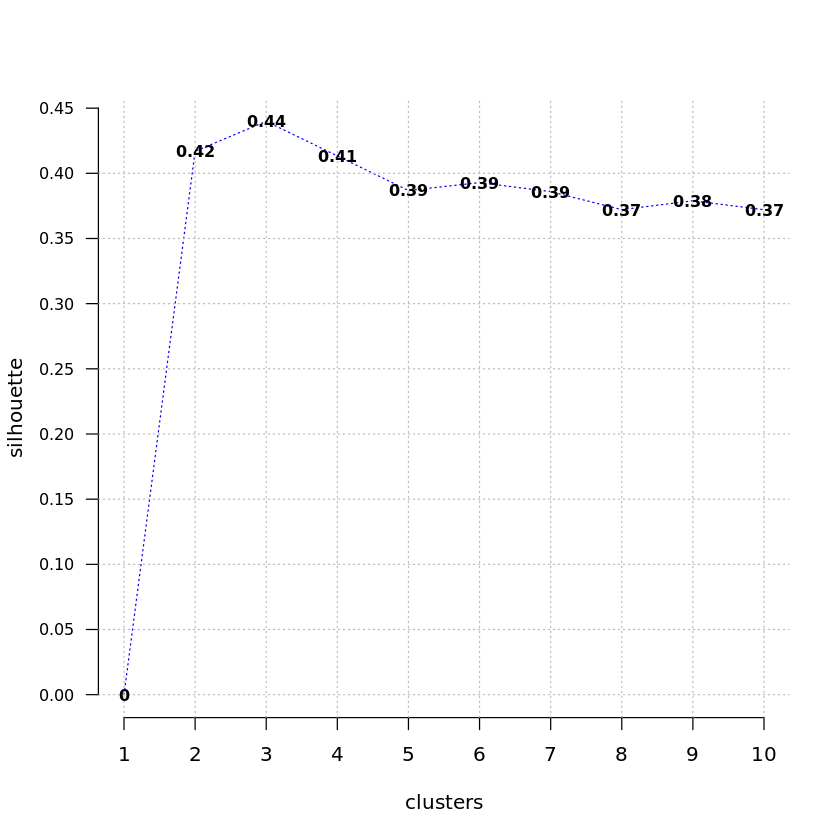

In [22]:
opt_km = Optimal_Clusters_KMeans(normalizeddata, 
                                 criterion = "silhouette", 
                                 max_clusters=10,
                                 plot_clusters = TRUE)

In [27]:
classif <- kmeans(normalizeddata, centers=1, iter.max=100, nstart=100)
kmcenters <- unPreProc(preProcValues, data.frame(classif$centers))
candidates <- rangeUnscale(kmcenters, my_bounds)
candidates

G,F
1.05727,10.23783


In [76]:
nrow(rangeUnscale(unPreProc(preProcValues, normalizeddata[classif$cluster==2,]), my_bounds))

[1] 35

In [77]:
library(xtable)

print.xtable(xtable(candidates))


Attaching package: ‘xtable’

The following object is masked from ‘package:spam’:

    display



% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Fri Feb 18 11:44:23 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & h & c & b \\ 
  \hline
1 & 1.00 & 10.26 & 10.03 \\ 
  2 & 1.05 & 16.98 & 10.41 \\ 
   \hline
\end{tabular}
\end{table}


# Ensemble of plausible simulations

In [78]:
### check if Kmeans centers are in NROY4
imps_kmeans <- ImplausibilityMOGP(NewData=kmcenters, Emulator=TestEm5, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
which(rowSums(imps_kmeans <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax4)

[1] 1 2

In [79]:
testpoints <- rangeUnscale(kmcenters, my_bounds)[rowSums(imps_kmeans <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax5,]

In [80]:
testpoints

h,c,b
1.000784,10.26192,10.03289
1.054902,16.97905,10.40691


In [81]:
write.csv(testpoints,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/finaltestpoints_newPCA_PhysPrior_classic_AMIP.csv", row.names = FALSE)

## summary of the HM

In [82]:
NROYs <- 100 * c(ratio1, ratio2, ratio3, ratio4, ratio5)
NbSim <- c(30, nrow(designpoints), nrow(designpoints2), nrow(designpoints3), nrow(designpoints4))

In [83]:
data.frame(NROYs, NbSim)

NROYs,NbSim
71.8623,30
12.1854,30
1.2358,30
0.1247,30
0.0090,30


In [84]:
print.xtable(xtable(data.frame(NROYs, NbSim)))

% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Fri Feb 18 11:44:46 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & NROYs & NbSim \\ 
  \hline
1 & 71.86 & 30.00 \\ 
  2 & 12.19 & 30.00 \\ 
  3 & 1.24 & 30.00 \\ 
  4 & 0.12 & 30.00 \\ 
  5 & 0.01 & 30.00 \\ 
   \hline
\end{tabular}
\end{table}


In [85]:
sum(NbSim)

[1] 150